##Usage Instructions
Run the first two cells consecutively. The cells following download data from the parameters selected for either a certain number of recent days or selected date ranges. Following that visualizations can be created using any of the fields that the sensors contain for up to two variables.

##JSON combiner transforms data into a workable list of dicts

In [1]:
#@title Run Combiner Function
from datetime import datetime, date, timezone, timedelta
import json
from glob import glob
import os


seconds_per_unit = {"s": 1, "m": 60, "h": 3600, "d": 86400, "w": 604800}
strfmt = {'year_month':'%Y-%m', 'day':"%d", 'time': '%H_%M_%S'}

def convert_to_seconds(s):
    return int(s[:-1]) * seconds_per_unit[s[-1]]

def combine_json(device, last='1h', start_date=None, end_date=None, file=''):
    """ combine json file readings for specific device 
    Parameters
    ----------
    device : str
        device ID 
    time : str (optional)
        Duration on which we want to get the data (default 1h). 
        Past 30s for the last 30 seconds, 1h for the last hour, 
        2d for the last 48 hours, etc
    
    file : str (optional)
        optional parameter to write combined json to file. Leave
        blank to not write to file
    Returns
    -------
    returns the JSON formated list sensor readings  
    NOTE
    ----
    -   units return as ASCII characters, regular print(combine_json(stuff)) will throw UnicodeEncodeError, 
        instead use print(json.dumps(combine_json(stuff)), be sure to 'import json' first
    """
    # TODO: check if device/directory exists
    
    next = True
    readings = []
    reading_jsons = []

    time_now = datetime.now(timezone.utc)
    # time_now = datetime(year=2021, month=1, day=20, hour=23)
    time_last = time_now - timedelta(seconds=convert_to_seconds(last))
    temp_day = time_now

    if start_date is not None:
        time_last = datetime.fromisoformat(start_date)
    if end_date is not None:
        temp_day = datetime.fromisoformat(end_date)

    # starts with most recent reading and works backwards to find last reading
    while(next):
        dir_readings = glob("SensorData/"+device+"/"+temp_day.strftime('%Y-%m')+"/" + temp_day.strftime('%d' + "/*"))

        if temp_day.date() == time_last.date(): 
            for i, r in enumerate(dir_readings):
                time_str = r[-13:-5]
                temp_time = datetime.strptime(time_str, '%H_%M_%S').time()
                if temp_time >= time_last.time():
                    reading_jsons.extend(dir_readings[i:])
                    break
            next = False
        else:
            reading_jsons.extend(dir_readings)

        temp_day -= timedelta(days=1)

    # print(reading_jsons)

    for reading in reading_jsons:
        with open(reading, 'r') as f:
            json_file = json.load(f)
            readings.append(json_file)
    
    # print(json.dumps(readings, indent=4))

    if file != '':
        with open(file, 'w') as f:
            json.dump(readings, f, indent=4)
    return readings

if __name__ == "__main__":
    combine1 = combine_json('dl-atm41_5245')  # last hour of readings for device 
    combine2 = combine_json('dl-atm41_5245', '2h')  # last 2 hours of readings for device, no json file created
    combine3 = combine_json('dl-atm41_5245', '3h', file='combined.json')  # last 3 hours of readings for device, json file created

    print(json.dumps(combine3, indent=4))

[]


## Define function to pull data from the things network via S3

In [4]:
#@title Run download function
#@title Import number of days
AWS_Access_Key_ID=''#@param {type:"string"}
AWS_Secret_Access_Key=''#@param {type:"string"}
from datetime import datetime, date, timezone, timedelta
from queue import Queue
!pip -q install boto3
import os, boto3


def download_from_S3(device, last=None, start_date=None, end_date=None):

    bucket_name = 'floodwarningsystem'
    
    # Convert start_date into type datetime
    if start_date is None:
        datetime_start_date = datetime.now(timezone.utc)
        if last is not None:
            number_of_days = int(last[:-1])
            datetime_start_date -= timedelta(days=number_of_days)
        start_date = datetime.strftime(datetime_start_date, '%Y-%m-%d')
    datetime_start_date = datetime.fromisoformat(start_date)

    # Convert end_date into type datetime
    if end_date is None:
        datetime_end_date = datetime.now(timezone.utc)
        end_date = datetime.strftime(datetime_end_date, '%Y-%m-%d')
    datetime_end_date = datetime.fromisoformat(end_date)
    
    # Create queue for parallel S3 downloads for each day's readings
    object_prefix = 'SensorData/{}/'.format(device)
    object_prefix_queue = Queue()

    current_date = datetime_start_date
    
    while current_date <= datetime_end_date:
        current_date_prefix = datetime.strftime(current_date, '%Y-%m/%d')
        current_date_object_prefix = object_prefix + current_date_prefix
        object_prefix_queue.put(current_date_object_prefix)
        current_date += timedelta(days=1)
    
    # s3 = boto3.resource('s3', aws_access_key_id = 'ENTER YOUR ACCESS KEY', 
    #                           aws_secret_access_key= 'ENTER YOUR SECRET KEY')
    s3 = boto3.resource('s3', aws_access_key_id = AWS_Access_Key_ID, aws_secret_access_key= AWS_Secret_Access_Key)
    s3_bucket = s3.Bucket(bucket_name)

    while not object_prefix_queue.empty():

        reading_object_prefix = object_prefix_queue.get()
        print('Downloading readings from \'{}\' directory...'.format(reading_object_prefix))

        for s3_object in s3_bucket.objects.filter(Prefix=reading_object_prefix):
            path, filename = os.path.split(s3_object.key)
            if not os.path.exists(path):
                os.makedirs(path)

            s3_bucket.download_file(s3_object.key, s3_object.key)
    
    print('Finished downloading selected readings!')


def combined_readings(device, last='1d', start_date=None, end_date=None, file=''):
    download_from_S3(device, last=last, start_date=start_date, end_date=end_date)
    return combine_json(device, last=last, start_date=start_date, end_date=end_date, file=file)


#Retrieving and manipulating data


###Run Cell Below to import the last selected number of days worth of data:

In [5]:
#@title Import number of days
days_import='1'#@param ["1","2","7","14","30"]
import_conv=str(days_import)+'d'
##import pressure data
pressure_data =combined_readings('dl-pr-26_5100', last=import_conv)

##import weather data
weather_data =combined_readings('dl-atm41_5245', last=import_conv)


##transform json into data frame
import pandas as pd
pressure_df=pd.DataFrame.from_dict(pressure_data, orient='columns')
weather_df=pd.DataFrame.from_dict(weather_data, orient='columns')

##create timestamp series
pressure_df['timestamp']=pd.to_datetime(pressure_df['time'])
weather_df['timestamp']=pd.to_datetime(weather_df['time'])

##create water density series and use to create water depth series
g=9.8
pressure_df['density']=999.83+0.0752*pressure_df['temperature']-0.0089*(pressure_df['temperature']**2)+(7.36413E-5)*(pressure_df['temperature']**3)+(4.74639E-7)*(pressure_df['temperature']**4)+(1.34888E-9)*(pressure_df['temperature']**5)
pressure_df['water depth']=(pressure_df['pressure']*100000)/(pressure_df['density']*g)

##merge data frames on timestamp
pressure_df=pressure_df.sort_values(by=['timestamp'])
weather_df=weather_df.sort_values(by=['timestamp'])
alldata=pd.merge_asof(pressure_df, weather_df, on='timestamp',direction='nearest')
alldata['Pressure Sensor Battery Voltage(V)']=alldata['battery_voltage_x']
alldata['Weather Sensor Battery Voltage(V)']=alldata['battery_voltage_y']
alldata['Water Pressure (bar)']=alldata['pressure']
alldata['Water Temperature (C)']=alldata['temperature']
alldata['Water Density (kg/m^3)']=alldata['density']
alldata['Water Depth (m)']=alldata['water depth']
alldata['Atmospheric Pressure (kPa)']=alldata['atmospheric_pressure']
alldata['Air Temperature (C)']=alldata['air_temperature']
alldata['Lightning Average Distance (km)']=alldata['lightning_average_distance']
alldata['Lightning Strike Count']=alldata['lightning_strike_count']
alldata['Maximum Wind Speed (m/s)']=alldata['maximum_wind_speed']
alldata['Precipitation (mm)']=alldata['precipitation']
alldata['Relative Humudity (%)']=alldata['relative_humidity']
alldata['Vapor Pressure (kPa)']=alldata['vapor_pressure']
alldata['Wind Speed (m/s)']=alldata['wind_speed']


Finished downloading selected readings!
Finished downloading selected readings!


###Run cell below after selecting date ranges to import data from a particular range of time:

In [ ]:
#@title Date Import Range
date_start='2021-03-11'#@param {type:"date"}
date_end='2021-03-19'#@param {type:"date"}

##import pressure data
pressure_data=combined_readings('dl-pr-26_5100', start_date=date_start, end_date=date_end)

##import weather data
weather_data =combined_readings('dl-atm41_5245', start_date=date_start, end_date=date_end)


##transform json into data frame
import pandas as pd
pressure_df=pd.DataFrame.from_dict(pressure_data, orient='columns')
weather_df=pd.DataFrame.from_dict(weather_data, orient='columns')

##create timestamp series
pressure_df['timestamp']=pd.to_datetime(pressure_df['time'])
weather_df['timestamp']=pd.to_datetime(weather_df['time'])

##create water density series and use to create water depth series
g=9.8
pressure_df['density']=999.83+0.0752*pressure_df['temperature']-0.0089*(pressure_df['temperature']**2)+(7.36413E-5)*(pressure_df['temperature']**3)+(4.74639E-7)*(pressure_df['temperature']**4)+(1.34888E-9)*(pressure_df['temperature']**5)
pressure_df['water depth']=(pressure_df['pressure']*100000)/(pressure_df['density']*g)

##merge data frames on timestamp
pressure_df=pressure_df.sort_values(by=['timestamp'])
weather_df=weather_df.sort_values(by=['timestamp'])
alldata=pd.merge_asof(pressure_df, weather_df, on='timestamp',direction='nearest')
alldata['Pressure Sensor Battery Voltage(V)']=alldata['battery_voltage_x']
alldata['Weather Sensor Battery Voltage(V)']=alldata['battery_voltage_y']
alldata['Water Pressure (bar)']=alldata['pressure']
alldata['Water Temperature (C)']=alldata['temperature']
alldata['Water Density (kg/m^3)']=alldata['density']
alldata['Water Depth (m)']=alldata['water depth']
alldata['Atmospheric Pressure (kPa)']=alldata['atmospheric_pressure']
alldata['Air Temperature (C)']=alldata['air_temperature']
alldata['Lightning Average Distance (km)']=alldata['lightning_average_distance']
alldata['Lightning Strike Count']=alldata['lightning_strike_count']
alldata['Maximum Wind Speed (m/s)']=alldata['maximum_wind_speed']
alldata['Precipitation (mm)']=alldata['precipitation']
alldata['Relative Humudity (%)']=alldata['relative_humidity']
alldata['Vapor Pressure (kPa)']=alldata['vapor_pressure']
alldata['Wind Speed (m/s)']=alldata['wind_speed']

Finished downloading selected readings!
Finished downloading selected readings!


##Create plots
Run each cell to generate individual vizualizations for titled fields

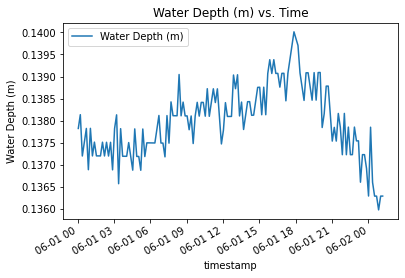

In [6]:
#@title Select plotting variables
field_1='Water Depth (m)'#@param ['None','Pressure Sensor Battery Voltage(V)','Weather Sensor Battery Voltage(V)','Water Pressure (bar)','Water Temperature (C)','Water Density (kg/m^3)','Water Depth (m)','Atmospheric Pressure (kPa)','Air Temperature (C)','Lightning Average Distance (km)','Lightning Strike Count','Maximum Wind Speed (m/s)','Precipitation (mm)','Relative Humudity (%)','Vapor Pressure (kPa)','Wind Speed (m/s)']
field_2='None'#@param  ['None','Pressure Sensor Battery Voltage(V)','Weather Sensor Battery Voltage(V)','Water Pressure (bar)','Water Temperature (C)','Water Density (kg/m^3)','Water Depth (m)','Atmospheric Pressure (kPa)','Air Temperature (C)','Lightning Average Distance (km)','Lightning Strike Count','Maximum Wind Speed (m/s)','Precipitation (mm)','Relative Humudity (%)','Vapor Pressure (kPa)','Wind Speed (m/s)']
##Create graphs depending on inputs
if field_2!='None' and field_1!='None':
  temp2plot=alldata.plot(x='timestamp',y=[field_1,field_2], title=field_1+' and '+field_2+' vs. Time')
  temp2plot.set_ylabel(field_1+' and '+field_2)
if field_2=='None':
  temp2plot=alldata.plot(x='timestamp',y=field_1, title=field_1+' vs. Time')
  temp2plot.set_ylabel(field_1)
if field_1=='None':
  temp2plot=alldata.plot(x='timestamp',y=field_2, title=field_2+' vs. Time')
  temp2plot.set_ylabel(field_2)